In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,Dropout,AveragePooling2D
import time
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import Callback, EarlyStopping

In [18]:
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split as tts
fashion = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

X_val,X_test,y_val,y_test = tts(X_test,y_test,test_size = 0.5)

In [19]:
def create_lenet_model(p):
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28,28,1), padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(Dropout(p))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(Dropout(p))
    model.add(Flatten())
    model.add(Dense(84, activation='relu'))
    model.add(Dropout(p))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [23]:
import numpy as np

def run_model(policy,no_dropout):
    val_loss = []
    training_loss = []
    dropouts = []
    if policy:
        p =0
    else:
        if no_dropout:
            p = 0
        else:
            p = 0.4
    dropouts.append(p)
    epochs = 100
    lookback = np.ceil(0.05*epochs)
    best_val_loss = 1000
    for i in range(1,epochs+1):
        print(f"Epoch {i}")
        if i == 1 :
            print("initial case")
            model = create_lenet_model(p)
            model.compile(optimizer= 'adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
            history=model.fit(X_train,y_train ,epochs=1, batch_size=64, validation_data=(X_val,y_val), verbose=1)
            model.save_weights('modelsofar.hd5')
            val_loss.append(history.history['val_loss'][0])
            training_loss.append(history.history['loss'][0])
            continue

        if policy and not (i+1)%lookback:
            avg_val = np.mean([loss for loss in val_loss[-5:]])
            avg_train = np.mean([loss for loss in training_loss[-5:]])
            loss_diff = abs(avg_train-avg_val)
            percentage_diff = loss_diff/avg_train
            p = percentage_diff
            if p>0.5:
                p = 0.5
        
        print(f'rate {p}')
        model = create_lenet_model(p)
        model.compile(optimizer= 'adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
        model.load_weights('modelsofar.hd5')   
        dropouts.append(p)
        history=model.fit(X_train,y_train ,epochs=1, batch_size=128, validation_data=(X_val,y_val), verbose=1)
        model.save_weights('modelsofar.hd5')
        # if history.history['val_loss'][0]<=best_val_loss:
        #     best_val_loss = history.history['val_loss'][0]
        #     model.save_weights('best_modelsofar.hd5')
        val_loss.append(history.history['val_loss'][0])
        training_loss.append(history.history['loss'][0])
    
    # model.load_weights('best_modelsofar.hd5')
    return model,training_loss,val_loss,dropouts

In [24]:
import matplotlib.pyplot as plt

policy_model,policy_train,policy_val,varying_dropouts = run_model(True,False)
model,train,val,_ = run_model(False,False)
nodropout_model,nodropout_train,nodropout_val,_ = run_model(False,True)

Epoch 1
initial case
938/938 [==============================] - 5s 5ms/step - loss: 0.5106 - accuracy: 0.8212 - val_loss: 0.4141 - val_accuracy: 0.8546
Epoch 2
rate 0
469/469 [==============================] - 3s 6ms/step - loss: 0.3231 - accuracy: 0.8824 - val_loss: 0.3301 - val_accuracy: 0.8784
Epoch 3
rate 0
469/469 [==============================] - 3s 6ms/step - loss: 0.2874 - accuracy: 0.8945 - val_loss: 0.3038 - val_accuracy: 0.8888
Epoch 4
rate 0
469/469 [==============================] - 3s 6ms/step - loss: 0.2650 - accuracy: 0.9014 - val_loss: 0.3069 - val_accuracy: 0.8842
Epoch 5
rate 0
469/469 [==============================] - 3s 6ms/step - loss: 0.2469 - accuracy: 0.9083 - val_loss: 0.2956 - val_accuracy: 0.8944
Epoch 6
rate 0
469/469 [==============================] - 3s 6ms/step - loss: 0.2305 - accuracy: 0.9139 - val_loss: 0.3039 - val_accuracy: 0.8934
Epoch 7
rate 0
469/469 [==============================] - 3s 7ms/step - loss: 0.2241 - accuracy: 0.9171 - val_loss: 0.

KeyboardInterrupt: 

Vanilla accuracy 0.9242
Vanilla f1 0.9241732641693396
Dynamic accuracy 0.9212
Dynamic f1 0.9208800141038637
No Dropout accuracy 0.9064
No Dropout f1 0.9077597043670298


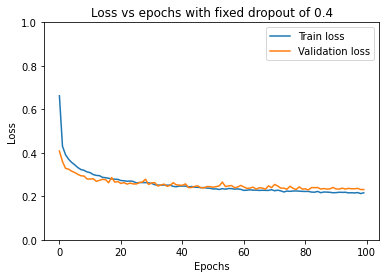

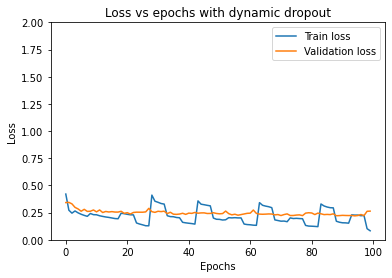

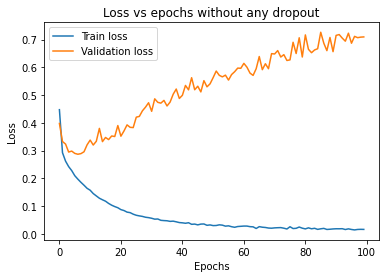

In [15]:
from sklearn.metrics import accuracy_score,f1_score
import json

epochs = 100

# with open('./fashionmnist/fashionmnist.txt') as f:
#     json_data = json.load(f)

# train = json_data['Vanilla']['train_loss']
# val = json_data['Vanilla']['val_loss']
# accuracy = json_data['Vanilla']['accuracy']
# f1 = json_data['Vanilla']['f1']

# policy_train = json_data['Dynamic']['train_loss']
# policy_val = json_data['Dynamic']['val_loss']
# accuracy_policy = json_data['Dynamic']['accuracy']
# f1_policy = json_data['Dynamic']['f1']

# nodropout_train = json_data['NoDrop']['train_loss']
# nodropout_val = json_data['NoDrop']['val_loss']
# accuracy_nodropout = json_data['NoDrop']['accuracy']
# f1_nodropout = json_data['NoDrop']['f1']


fig1 = plt.figure()
plt.title("Loss vs epochs with fixed dropout of 0.4")
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(epochs),train,label = 'Train loss')
plt.plot(range(epochs),val, label = 'Validation loss')
plt.legend()
plt.savefig('./fashionmnist/nopolicy')
fig1.show()

fig2 = plt.figure()
plt.title("Loss vs epochs with dynamic dropout")
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(epochs),policy_train,label = 'Train loss')
plt.plot(range(epochs),policy_val, label = 'Validation loss')
plt.legend()
plt.savefig('./fashionmnist/policy')
fig2.show()

fig3 = plt.figure()
plt.title("Loss vs epochs without any dropout")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(epochs),nodropout_train,label = 'Train loss')
plt.plot(range(epochs),nodropout_val, label = 'Validation loss')
plt.legend()
plt.savefig('./fashionmnist/nodropout')
fig3.show()

fig4 = plt.figure()
plt.ylim(0,0.5)
plt.title("Dropout variation across epochs")
plt.xlabel('Epochs')
plt.ylabel('Dropout rate')
plt.plot(range(epochs),varying_dropouts,color = 'r')
plt.savefig('./cifar10/dropouts')
fig4.show()




pred = model.predict(X_test)
pred_classes = np.argmax(pred,axis=1)
truth = np.argmax(y_test,axis=1)
f1 = f1_score(pred_classes,truth,average='macro')
accuracy = accuracy_score(pred_classes,truth)
print(f"Vanilla accuracy {accuracy}")
print(f"Vanilla f1 {f1}")

pred = policy_model.predict(X_test)
pred_classes = np.argmax(pred,axis=1)
truth = np.argmax(y_test,axis=1)
f1_policy = f1_score(pred_classes,truth,average='macro')
accuracy_policy = accuracy_score(pred_classes,truth)
print(f"Dynamic accuracy {accuracy_policy}")
print(f"Dynamic f1 {f1_policy}")


pred = nodropout_model.predict(X_test)
pred_classes = np.argmax(pred,axis=1)
truth = np.argmax(y_test,axis=1)
f1_nodropout = f1_score(pred_classes,truth,average='macro')
accuracy_nodropout = accuracy_score(pred_classes,truth)
print(f"No Dropout accuracy {accuracy_nodropout}")
print(f"No Dropout f1 {f1_nodropout}")

scores = {
          'Dynamic':{
                    'accuracy':accuracy_policy,
                    'f1':f1_policy,
                    'train_loss':policy_train,
                    'val_loss':policy_val
                  },
          'Vanilla':{
                    'accuracy':accuracy,
                    'f1':f1,
                    'train_loss':train,
                    'val_loss':val
          },
        'NoDrop':{
                    'accuracy':accuracy_nodropout,
                    'f1':f1_nodropout,
                    'train_loss':nodropout_train,
                    'val_loss':nodropout_val
          },
         }
          
output_string = json.dumps(scores)

with open("fashionmnist/fashionmnist.txt","w+") as file:
    file.write(output_string)